<!DOCTYPE html>
<html>
  <body>
    <div align=center>
      <h1><b>Organización de Datos</b></h1>
      <p>Cátedra Rodriguez - 95.58</p>
      <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/FIUBA_gris_transparente.png/800px-FIUBA_gris_transparente.png" alt="logo" width="300">
      <h2><b>Trabajo Práctico N°1: Reservas de Hotel</b></h2>
    </div>
    <h3>Integrantes del <b>Grupo 17 (Systeam)</b></h3>
    <ul>
        <li>Agha Zadeh Dehdeh, Lucía. P: 106905</li>
        <li>Brizuela, Sebastián. P: 105288</li>
        <li>Del Rio, Juan Sebastián. P: 103337</li>
    </ul>
  </body>
</html>

# Librerías

In [ ]:
import pandas as pd
import numpy as np

import joblib

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns

#Modelos y métricas
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

#Configuración warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

# Dataframe principal

### Carga del dataframe

In [ ]:
DF_HOTEL_TRAIN = pd.read_csv("./sample_data/hotel_train_procesado.csv") # Cargamos en memoria el dataset

In [ ]:
df_hotel_copy = DF_HOTEL_TRAIN.copy()

###Preprocesamiento

Se determinó como nuevas variables relevantes “market_segment“, “distribution_channel“, “customer_type“, “required_car_parking_spaces“ al analizar nuevamente los gráficos, realizar pruebas con los modelos implementados y ver una mejoría en las métricas.

In [ ]:
columnas_a_eliminar = [
    "children", "arrival_date_year", "arrival_date_month",
    "arrival_date_week_number", "arrival_date_day_of_month",
    "stays_in_weekend_nights", "stays_in_week_nights", "babies",
    "meal", "adr", "id", "cantidad_personas_total"
]

df_hotel_copy.drop(columnas_a_eliminar, axis="columns", inplace=True)


In [ ]:
columnas_categoricas = ["hotel", "country", "reserved_room_type", "assigned_room_type", "deposit_type","agent", 'market_segment', 'distribution_channel', 'customer_type']

#One Hot encoding
df_hotel_copy = pd.get_dummies(df_hotel_copy, columns=columnas_categoricas, drop_first=True)


In [ ]:
df_hotel_copy.sort_index(axis="columns", inplace=True) # Reordeno para que coincida el orden con df_hotel_test

## Target

In [ ]:
target = "is_canceled"

#Se muestra el porcentaje de aparición de cada clase
df_hotel_copy[target].value_counts(normalize=True) * 100

1    50.221485
0    49.778515
Name: is_canceled, dtype: float64

## División de datos entrenamiento y prueba

In [ ]:
df_hotel_copy_x = df_hotel_copy.drop([target], axis="columns" ,inplace=False)

df_hotel_copy_y = df_hotel_copy[target].copy()

x_train, x_test, y_train, y_test = train_test_split(df_hotel_copy_x, df_hotel_copy_y, test_size = 0.2, random_state = 17, stratify = df_hotel_copy[target].values)

print(f"# Datos Entrenamiento: {len(x_train)}")
print(f"# Datos Prueba: {len(x_test)}")

# Datos Entrenamiento: 48220
# Datos Prueba: 12055


#Importación de modelos

Para agilizar la ejecución de los algoritmos utilizamos copias de la notebook para entrenar los modelos en paralelo.

Para la importación y exportación de los mismos utilizamos la librería joblib.

# KNN

###Carga de modelos

In [ ]:
# Cargar el modelo desde un archivo Joblib
knn_modelo_importado = joblib.load('modelo_knn.joblib')

### Busqueda de los mejores hiperparámetros

In [ ]:
#Grilla de Parámetros
params_grid = { 'n_neighbors':range(10,15),
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn = KNeighborsClassifier()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='f1', n_iter=10, random_state=5)

rand.fit(x_train, y_train)

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(),
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': range(10, 15),
                                        'weights': ['distance', 'uniform']},
                   random_state=5, scoring='f1')

In [ ]:
#Mejores hiperparametros
print(rand.best_params_)

#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 14, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
0.8183606574448845


### KNN con mejores parámetros

In [ ]:
#Mejor estimador
knn = rand.best_estimator_

KNeighborsClassifier(algorithm='kd_tree', metric='manhattan', n_neighbors=14,
                     weights='distance')

### Predicción

In [ ]:
#Predicción con mejor estimador
y_pred_knn = knn_modelo_importado.predict(x_test)

### Métricas

In [ ]:
#Calculo las métricas en el conjunto de evaluación
print("Accuracy: ", accuracy_score(y_test, y_pred_knn))
print("Recall: ", recall_score(y_test, y_pred_knn))
print("Precision: ", f1_score(y_test, y_pred_knn))
print("f1 score: ", precision_score(y_test, y_pred_knn))

Accuracy:  0.8062214848610535
Recall:  0.8574496200858936
Precision:  0.8163233212769303
f1 score:  0.7789615846338536


## Matriz de confusión

Text(50.722222222222214, 0.5, 'True')

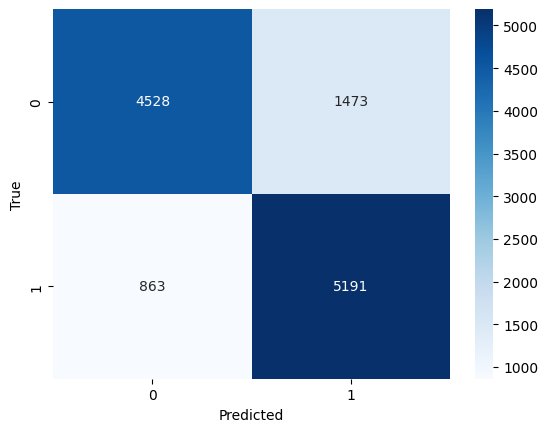

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

# SVC

In [ ]:
#Escalamos los datos con normalización
stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm = stand_scaler.transform(x_test)

## SVC - Kernel lineal

###Importación del modelo

In [ ]:
# Cargar el modelo desde un archivo Joblib
svc_lineal_modelo_importado = joblib.load('modelo_svc_lineal.joblib')

###Entrenamiento

In [ ]:
#Creo un clasificador con kernel lineal y lo entreno sobre los datos escalados min-max
svc_lineal = SVC(kernel='linear', C=5)
svc_lineal.fit(x_train_norm, y_train)

SVC(C=5, kernel='linear')

### Predicción

In [ ]:
#Hago la predicción y calculo las métricas
y_pred_lin = svc_lineal_modelo_importado.predict(x_test_norm)

### Métricas

In [ ]:
#Calculo las métricas en el conjunto de evaluación
print("Accuracy: ", accuracy_score(y_test, y_pred_lin))
print("Recall: ", recall_score(y_test, y_pred_lin))
print("Precision: ", f1_score(y_test, y_pred_lin))
print("f1 score: ", precision_score(y_test, y_pred_lin))

Accuracy:  0.8193280796350062
Recall:  0.8377931945820944
Precision:  0.8232429800357084
f1 score:  0.8091895341416719


### Matriz de confusión

Text(50.722222222222214, 0.5, 'True')

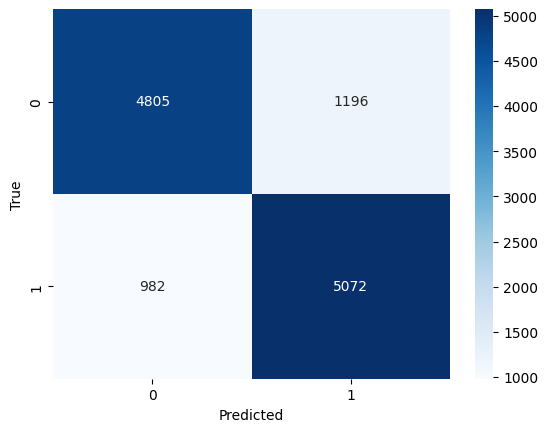

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_lin)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
#Creo un clasificador con kernel polinomico y lo entreno sobre los datos escalados min-max
svc_poli = SVC(kernel='poly', C=5)
svc_poli.fit(x_train_norm, y_train)

#Hago la predicción y calculo las métricas
y_pred_pol=svc_poli.predict(x_test_norm)

## SVC - Kernel radial

###Importación del modelo

In [ ]:
# Cargar el modelo desde un archivo Joblib
svc_radial_modelo_importado = joblib.load('modelo_svc_radial.joblib')

In [ ]:
#Creo un clasificador con kernel radial.
svc_radial = SVC(kernel='rbf', C=5, gamma=0.1)
svc_radial.fit(x_train_norm, y_train)

###Predicción

In [ ]:
#Hago la predicción y calculo las métricas
y_pred_rad=svc_radial_modelo_importado.predict(x_test_norm)

### Métricas

In [ ]:
#Calculo las métricas en el conjunto de evaluación
print("Accuracy: ", accuracy_score(y_test, y_pred_rad))
print("Recall: ", recall_score(y_test, y_pred_rad))
print("Precision: ", f1_score(y_test, y_pred_rad))
print("f1 score: ", precision_score(y_test, y_pred_rad))

Accuracy:  0.8389879717959353
Recall:  0.8442352163858606
Precision:  0.8404176601167475
f1 score:  0.8366344737272876


### Matriz de confusión

Text(50.722222222222214, 0.5, 'True')

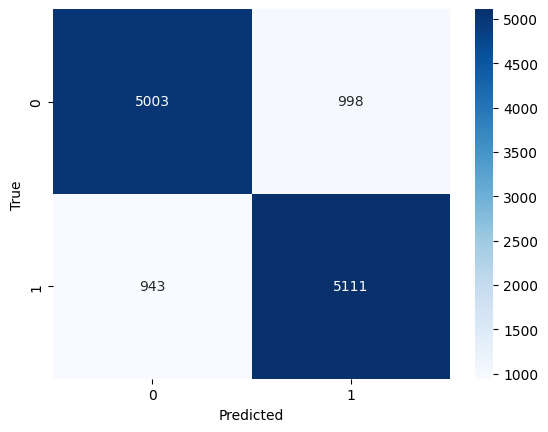

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_rad)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

# Ensambles

## Primera opción (RandomForestClassifier y RandomSearchCV)

###Importación del modelo

In [ ]:
# Cargar el modelo desde un archivo Joblib
rf_modelo_importado = joblib.load('modelo_random_forest.joblib')

### Busqueda de los mejores hiperparámetros

In [ ]:
#Cantidad de combinaciones que quiero porbar
n = 5

#Conjunto de parámetros que quiero usar
params_grid = {
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": range(30, 35),
    "min_samples_split":  range(50, 55),
    "ccp_alpha": np.linspace(0, 0.05, n),
    "max_depth": range(35, 40),
    "n_estimators": range(199, 350)
}

In [ ]:
#KFold Estratificado

#Cantidad de splits para el Cross Validation
folds = 5

kfoldcv = StratifiedKFold(n_splits=folds)

In [ ]:
#Clasificador
base_tree = RandomForestClassifier()

In [ ]:
#Random Search Cross Validation
rand_random_forest = RandomizedSearchCV(estimator = base_tree,
                              param_distributions = params_grid,
                              scoring = "f1",
                              cv = kfoldcv,
                              n_iter = n)

In [ ]:
#Busco los hiperparamtros que optimizan F1 Score
rand_random_forest.fit(x_train, y_train)

In [ ]:
#Mejores hiperparametros del arbol
print(rand_random_forest.best_params_)

#Mejor métrica
print(rand_random_forest.best_score_)

### Árbol con mejores parámetros

In [ ]:
#Creo el árbol con los mejores hiperparámetros
random_forest = rand_random_forest.best_estimator_

### Predicción

In [ ]:
y_pred_random_forest = rf_modelo_importado.predict(x_test)

### Métricas

In [ ]:
#Calculo las métricas en el conjunto de evaluación
print("Accuracy: ", accuracy_score(y_test, y_pred_random_forest))
print("Recall: ", recall_score(y_test, y_pred_random_forest))
print("Precision: ", f1_score(y_test, y_pred_random_forest))
print("f1 score: ", precision_score(y_test, y_pred_random_forest))

Accuracy:  0.8209871422646204
Recall:  0.763627353815659
Precision:  0.8107681515257805
f1 score:  0.8641121495327103


### Matriz de confusión

In [ ]:
#Matriz de Confusion
cm = confusion_matrix(y_test, y_pred_random_forest)

Text(50.722222222222214, 0.5, 'True')

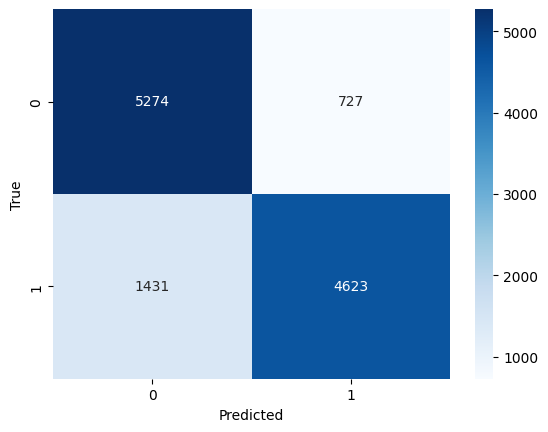

In [ ]:
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel("Predicted")
plt.ylabel("True")

## Segunda opción (XGBoost y RandomSearchCV)

###Importación del modelo

In [ ]:
# Cargar el modelo desde un archivo Joblib
xgb_modelo_importado = joblib.load('modelo_xgb.joblib')

### Busqueda de los mejores hiperparámetros

In [ ]:
xgb_model = xgb.XGBClassifier()

params_grid = {
    'n_estimators': range(50, 200, 10),
    'max_depth': range(3, 10),
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

In [ ]:
rand_xgb = RandomizedSearchCV(xgb_model,
                              param_distributions=params_grid,
                              n_iter=10,
                              scoring='f1',
                              n_jobs=-1,
                              cv=5,
                              verbose=1,
                              random_state=42)

rand_xgb.fit(x_train, y_train)

In [ ]:
#Mejores hiperparametros
print(rand_xgb.best_params_)

#Mejor métrica
print(rand_xgb.best_score_)

### XGB con mejores parámetros

In [ ]:
#Mejor estimador
xgb_mejores_parametros = rand_xgb.best_estimator_

### Predicción

In [ ]:
#Predicción con mejor estimador
y_pred_xgb = xgb_modelo_importado.predict(x_test)

### Métricas

In [ ]:
#Calculo las métricas en el conjunto de evaluación
print("Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("Recall: ", recall_score(y_test, y_pred_xgb))
print("Precision: ", f1_score(y_test, y_pred_xgb))
print("f1 score: ", precision_score(y_test, y_pred_xgb))

Accuracy:  0.8611364579012858
Recall:  0.8685166831846713
Precision:  0.8626743232157507
f1 score:  0.8569100391134289


### Matriz de confusión

Text(50.722222222222214, 0.5, 'True')

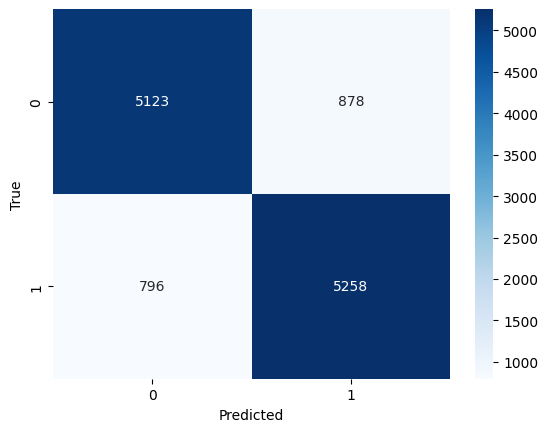

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

# Ensambles híbridos

## Voting

In [ ]:
#Creamos clasificadores
xgb_vot = xgb_modelo_importado
rnd_fst_vot = rf_modelo_importado
knn_vot = knn_modelo_importado

#Creamos ensamble de Votación
voting = VotingClassifier(estimators = [('xgb', xgb_vot), ('rnd_fst', rnd_fst_vot), ('knn', knn_vot)],
                          voting = 'hard')

#Entrenamos el ensamble
voting.fit(x_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=170, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('rnd_fst',
                              RandomForestClassifier(max_depth=35,
                                                     min_samples_leaf=31,
                                                     min_samples_split=53,
                                                     n_estimators=269)),
                             ('knn',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   metric='manhattan',
                                                   n_neighbors=14,
                                                   weights='distance'))])

### Predicción

In [ ]:
y_pred_vot = voting.predict(x_test)

### Métricas

In [ ]:
#Calculo las métricas en el conjunto de evaluación
print("Accuracy: ", accuracy_score(y_test, y_pred_vot))
print("Recall: ", recall_score(y_test, y_pred_vot))
print("Precision: ", f1_score(y_test, y_pred_vot))
print("f1 score: ", precision_score(y_test, y_pred_vot))

Accuracy:  0.8543343011198673
Recall:  0.8412619755533531
Precision:  0.8529559537765868
f1 score:  0.8649796195652174


### Matriz de confusión

In [ ]:
#Matriz de Confusion
cm = confusion_matrix(y_test, y_pred_vot)

Text(50.722222222222214, 0.5, 'True')

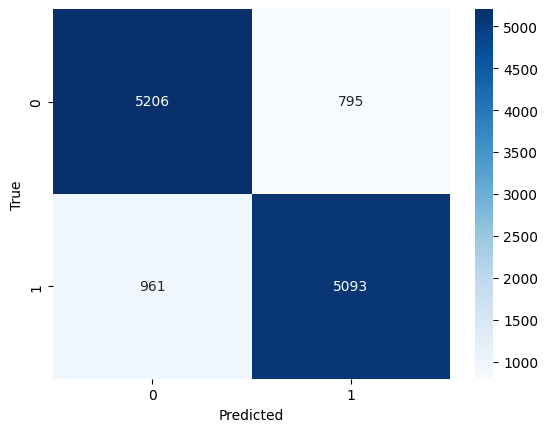

In [ ]:
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel("Predicted")
plt.ylabel("True")

## Stacking

In [ ]:
#Modelos Base
base_models = [('rnd_fst_stac', RandomForestClassifier(n_estimators=100)),
               ('knn_stac', KNeighborsClassifier(n_neighbors=15))
               ]

#Meta Modelo
meta_model = xgb.XGBClassifier()

#Creamos el ensamble Stacking
stacking = StackingClassifier(estimators=base_models,
                                    final_estimator=meta_model,
                                    passthrough=True,
                                    cv=5,
                                    verbose=2)

#Entrenamos el ensamble
stacking.fit(x_train,y_train)

StackingClassifier(cv=5,
                   estimators=[('rnd_fst_stac', RandomForestClassifier()),
                               ('knn_stac',
                                KNeighborsClassifier(n_neighbors=15))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 device=None,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric=None...
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   passthrough=True, verbose=2)

### Predicción

In [ ]:
y_pred_stac = stacking.predict(x_test)

### Métricas

In [ ]:
#Calculo las métricas en el conjunto de evaluación
print("Accuracy: ", accuracy_score(y_test, y_pred_stac))
print("Recall: ", recall_score(y_test, y_pred_stac))
print("Precision: ", f1_score(y_test, y_pred_stac))
print("f1 score: ", precision_score(y_test, y_pred_stac))

Accuracy:  0.8637909581086686
Recall:  0.8688470432771721
Precision:  0.8649893109685908
f1 score:  0.8611656843483956


### Matriz de confusión

In [ ]:
#Matriz de Confusion
cm = confusion_matrix(y_test, y_pred_stac)

Text(50.722222222222214, 0.5, 'True')

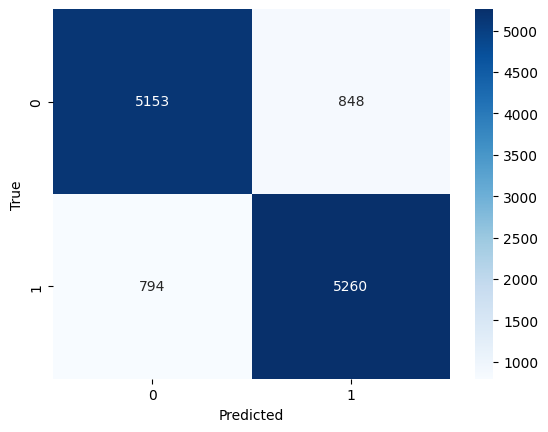

In [ ]:
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel("Predicted")
plt.ylabel("True")

# Predicción con DF_HOTEL_TEST

### Carga del DataFrame TEST

In [ ]:
DF_HOTEL_TEST = pd.read_csv(("./sample_data/hotels_test.csv"))

In [ ]:
df_hotel_test_copy = DF_HOTEL_TEST.copy()

## Preprocesamiento

### Tratamiento de datos faltantes

In [ ]:
df_hotel_test_copy['agent'] = df_hotel_test_copy['agent'].fillna("Agencia no existe")

df_hotel_test_copy['country'] = df_hotel_test_copy['country'].fillna(df_hotel_test_copy['country'].mode()[0])

### Eliminación de variables irrelavantes y/o con datos faltantes

In [ ]:
columnas_a_eliminar = [
    "children", "arrival_date_year", "arrival_date_month",
    "arrival_date_week_number", "arrival_date_day_of_month",
    "stays_in_weekend_nights", "stays_in_week_nights", "babies",
    "meal", "adr", "id", "company"
]
df_hotel_test_copy.drop(columnas_a_eliminar, axis="columns", inplace=True)

### Transformación de las variables categoricas

In [ ]:
#One Hot encoding
df_hotel_test_copy = pd.get_dummies(df_hotel_test_copy, columns=columnas_categoricas, drop_first=True)

## Emparejamiento de los dataframes

In [ ]:
columnas_df_train = set(df_hotel_copy.columns) # Obtiene las columnas del primer DataFrame
columnas_df_test = set(df_hotel_test_copy.columns) # Obtiene las columnas del segundo DataFrame

In [ ]:
columnas_distintas = columnas_df_test.difference(columnas_df_train) # Encuentra las columnas que son distintas entre los DataFrames
print(columnas_distintas)

{'agent_211.0', 'country_MLI', 'country_UZB', 'agent_282.0', 'country_DJI', 'agent_213.0', 'agent_331.0', 'reserved_room_type_P', 'country_NIC', 'agent_510.0', 'country_ATF', 'agent_363.0', 'assigned_room_type_P', 'agent_444.0', 'agent_165.0', 'agent_122.0', 'country_SLV', 'country_TMP', 'agent_358.0', 'agent_397.0', 'agent_337.0', 'reservation_status_date', 'country_DMA', 'agent_367.0', 'country_KHM', 'country_ASM', 'country_SMR', 'country_BFA', 'agent_469.0', 'agent_135.0', 'agent_150.0', 'agent_232.0'}


In [ ]:
df_hotel_test_copy.drop(columnas_distintas, axis="columns", inplace=True) ##DESPUES CAMBIAR SOLUCIÓN

In [ ]:
columnas_distintas = columnas_df_train.difference(columnas_df_test) # Encuentra las columnas que son distintas entre los DataFrames
print(columnas_distintas)

{'country_SYC', 'country_COM', 'country_ZMB', 'country_ETH', 'agent_430.0', 'country_MNE', 'country_AZE', 'agent_179.0', 'agent_267.0', 'agent_247.0', 'agent_291.0', 'agent_59.0', 'agent_214.0', 'agent_451.0', 'country_SYR', 'market_segment_Undefined', 'agent_404.0', 'agent_431.0', 'agent_414.0', 'country_FRO', 'agent_93.0', 'agent_304.0', 'agent_114.0', 'country_ARM', 'agent_476.0', 'country_MDG', 'country_KNA', 'assigned_room_type_L', 'agent_388.0', 'agent_107.0', 'agent_299.0', 'agent_497.0', 'agent_144.0', 'agent_289.0', 'agent_333.0', 'country_GTM', 'agent_167.0', 'country_SDN', 'agent_301.0', 'country_PYF', 'agent_438.0', 'agent_416.0', 'agent_321.0', 'agent_278.0', 'agent_391.0', 'agent_449.0', 'agent_483.0', 'agent_455.0', 'country_MUS', 'agent_450.0', 'country_FJI', 'country_NAM', 'agent_432.0', 'distribution_channel_Undefined', 'country_BEN', 'country_CIV', 'agent_173.0', 'agent_472.0', 'agent_24.0', 'agent_535.0', 'country_UMI', 'agent_405.0', 'agent_509.0', 'agent_197.0', '

In [ ]:
for columna in columnas_distintas:
  df_hotel_test_copy[columna] = 0

In [ ]:
df_hotel_test_copy.drop(["is_canceled"], axis="columns", inplace=True)

### Reordenamiento

In [ ]:
df_hotel_test_copy.sort_index(axis="columns", inplace=True)

## Predicción del conjunto de test y submits para la competencia Kaggle

In [ ]:
test_pred = stacking.predict(df_hotel_test_copy)
print(test_pred)

[1 1 0 ... 1 1 0]


### Resultado

In [ ]:
df_resultado = pd.DataFrame(
    {"id": DF_HOTEL_TEST["id"],
    "is_canceled": test_pred}
)

In [ ]:
df_resultado.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


### Exportación

In [ ]:
df_resultado.to_csv("resultado_stacking.csv", index=False)

# Guardado del modelo

In [ ]:
joblib.dump(stacking, "modelo_stacking.joblib")

['modelo_stacking.joblib']